In [1]:
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

from torchvision import models
from torchvision import transforms
from torchvision.io import read_image

import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split

from tqdm import tqdm

import random
import os

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
class CustomImageDataset(Dataset):
    def __init__(self, df, transform=None):

        self.df = df
        
        self.device = device
        
        self.transform = transform

    def __len__(self):
        return len(self.df)


    def __getitem__(self, idx):
        if idx >= len(self): raise StopIteration

        img = read_image(self.df.loc[idx, 'img_path'])[:3,:,:]
        filename = self.df.loc[idx, 'filename']
        sign = self.df.loc[idx, 'sign']
        
        if self.transform:
            img = self.transform(img)

        return img, filename, sign
    
    def getData(self):
        return list(self)

In [6]:
def createDataFrame():
    
    train_df = pd.read_csv('../data/train.csv')
    train_df['img_path'] = '../data/avia-train/avia-train/' + train_df['filename'] + '.png'
    
    test_df = pd.read_csv('../data/test.csv')
    test_df['img_path'] = '../data/avia-test/avia-test/' + test_df['filename'] + '.png'
    test_df['sign'] = -1
    
    test_e_df = pd.read_csv('../data/test_extended.csv', index_col='filename')
    
    test_e_df = test_e_df.drop(test_df['filename'])
    test_e_df['filename'] = test_e_df.index
    
    test_e_df['img_path'] = '../data/avia-test-extended/avia-test-extended/' + test_e_df['filename'] + '.jpeg'
    test_e_df['sign'] = -1
    
    df = pd.concat((train_df, test_df, test_e_df)).reset_index(drop=True)
    
    df['sign'] = df['sign'].astype('float64')
    
    return df

In [7]:
def createDataLoader(df, batch_size=None, shuffle=False, transform=None):

    batch_size = batch_size if batch_size else len(df)
    
    dataset = CustomImageDataset(df, transform=transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    
    return dataset, dataloader

In [8]:
df = createDataFrame()

In [9]:
model = models.resnet152(pretrained=True)
    
model.fc = torch.nn.Sequential(
    nn.Linear(model.fc.in_features, 1),
    nn.Sigmoid()
)

weight = torch.tensor([sum(df['sign'] == 1) / sum(df['sign'] != -1)])
criterion = nn.BCELoss(weight=weight, reduction='mean')
criterion.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [10]:
%%time

def f():
    log = {'loss': {'train': [], 'val': []}, 'bestModel': None}
    
    epochs = 50
    
    train_df, val_df = train_test_split(df[df['sign'] != -1], test_size=0.2, random_state=42)
    train_df, val_df = train_df.reset_index(drop=True), val_df.reset_index(drop=True)
    
    traintransform = transforms.Compose([
        transforms.ToPILImage(),

        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),

        transforms.ToTensor(),
    ])
    _, train_dataloader = createDataLoader(train_df, batch_size=500, shuffle=True, transform=traintransform)
    
    valTransform = transforms.Compose([
        transforms.ToPILImage(),

        transforms.ToTensor(),
    ])
    _, val_dataloader = createDataLoader(val_df, batch_size=500, shuffle=True, transform=valTransform)
    
    
    model.to(device)
    
    for epoch in range(epochs):
        # Train
        model.train()
        running_loss = 0
        for X, _, y in train_dataloader:
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device).float().reshape(-1, 1)
            
            y_predict = model(X)

            loss = criterion(y_predict, y)
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
        log['loss']['train'].append(running_loss/len(train_dataloader))
        
        # Val
        model.eval()
        running_loss = 0
        for X, _, y in val_dataloader:
            
            X, y = X.to(device), y.to(device).float().reshape(-1, 1)
            y_predict = model(X)
            
            
            loss = criterion(y_predict, y)
            running_loss += loss.item()
            
    
        log['loss']['val'].append(running_loss/len(val_dataloader))
        
        if not log['bestModel'] or log['loss']['val'][-1] < min(log['loss']['val'][:-1]):
            log['bestModel'] = model
            log['bestEpoch'] = epoch + 1
        
        print(f"Epoch: {epoch+1} / {epochs} | Train loss: {log['loss']['train'][-1]} | Val loss: {log['loss']['val'][-1]}")
            
    return log
        
log = f()    

Epoch: 1 / 50 | Train loss: 0.045222502890974285 | Val loss: 0.023129606906038064
Epoch: 2 / 50 | Train loss: 0.013939284449443222 | Val loss: 0.01189832342788577
Epoch: 3 / 50 | Train loss: 0.009474397348240017 | Val loss: 0.012297782223098554
Epoch: 4 / 50 | Train loss: 0.008305337042547762 | Val loss: 0.011473921378358053
Epoch: 5 / 50 | Train loss: 0.006512676835991442 | Val loss: 0.010766511138242025
Epoch: 6 / 50 | Train loss: 0.005678602657280862 | Val loss: 0.009546409307334285
Epoch: 7 / 50 | Train loss: 0.004287508680135943 | Val loss: 0.010364189385794677
Epoch: 8 / 50 | Train loss: 0.0038139008055441083 | Val loss: 0.011135186731385497
Epoch: 9 / 50 | Train loss: 0.0027642128290608524 | Val loss: 0.012050038758808604
Epoch: 10 / 50 | Train loss: 0.0031999400741187854 | Val loss: 0.00979063708263521
Epoch: 11 / 50 | Train loss: 0.0027445615036413074 | Val loss: 0.011142139323055744
Epoch: 12 / 50 | Train loss: 0.002733394522801973 | Val loss: 0.013391903100105433
Epoch: 13 /

49


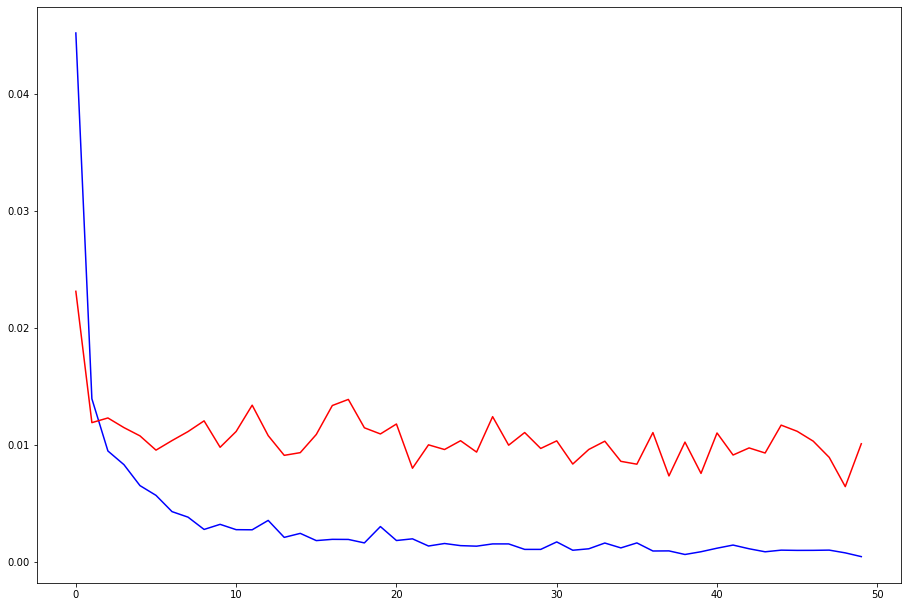

In [11]:
print(log['bestEpoch'])

fig = plt.figure()
axes = fig.add_axes([1, 1, 2, 2])

axes.plot(range(len(log['loss']['train'])), log['loss']['train'], 'b')
axes.plot(range(len(log['loss']['val'])), log['loss']['val'], 'r')
plt.show()

In [12]:
model = log['bestModel']

In [13]:
%%time
with torch.no_grad():
    model.eval()
    model.to(device)

    test_df = df[df['sign'] == -1]
    test_df = test_df.reset_index(drop=True)
    
    testTransform = transforms.Compose([
        transforms.ToPILImage(),

        transforms.ToTensor(),
    ])
    _, test_dataloader = createDataLoader(test_df, batch_size=500, shuffle=True, transform=testTransform)
    
    filenames = []
    predicteds = []
    
    for X, filename, _ in test_dataloader:
        X = X.to(device)
        y_predicted = model(X)
        y_predicted = y_predicted.reshape(-1).cpu()
        
        filenames += filename
        predicteds.append(y_predicted)
        
predicteds = torch.cat(predicteds, 0)

Wall time: 2min


In [14]:
predict_df = pd.DataFrame({
    'sign': predicteds,
    'filename': filenames
})

In [15]:
predict_df

sign                              filename
0       0.000067  297397cf-c83c-449d-a382-e807f227483d
1       0.000096  5b9ede36-a35d-4441-b8d3-0bc06f3a909c
2       0.000052  78780942-e4bc-4ce8-a595-e4db460debea
3       0.000050  96d9faed-d56c-48d2-87a1-4261306987ef
4       0.000061  33c558ae-fb13-4b07-93e0-023eea1b7dc6
...          ...                                   ...
100995  0.000060  5e118035-c882-46a2-a5e4-09d81771a0ad
100996  0.000065  7c1bf2a6-fdf4-44ce-8b54-b520eb41d09a
100997  0.000056  4bee31a1-f19e-496c-903c-881b60923cd7
100998  0.000062  3fe1ecbf-acea-492d-a663-0f3a996119da
100999  0.000183  cd962e63-c6be-4103-ada6-dbb46bc1947d

[101000 rows x 2 columns]

In [17]:
predict_df.to_csv('../predict/7.csv', index=False)